In [1]:
import os
import tempfile
import scanpy as sc
import scvi
import seaborn as sns
import torch
import anndata

Global seed set to 0


In [2]:
adata_atac_train_tgt = sc.read_h5ad("/lustre/groups/ml01/workspace/ot_perturbation/data/multiome/GLI3_KO_multiome_18d_adata_tgt_train_processed.h5ad")
adata_atac_train_src = sc.read_h5ad("/lustre/groups/ml01/workspace/ot_perturbation/data/multiome/GLI3_KO_multiome_18d_adata_src_atac_train_processed.h5ad")

In [3]:
adata_atac = sc.read_h5ad("/lustre/groups/ml01/workspace/ot_perturbation/data/multiome/GLI3_KO_multiome_18d_srt_peaks.h5ad")

In [4]:
adata_atac_train_tgt.layers["peaks"] = adata_atac[adata_atac_train_tgt.obs_names, adata_atac_train_tgt.var_names].X
adata_atac_train_src.layers["peaks"] = adata_atac[adata_atac_train_src.obs_names, adata_atac_train_tgt.var_names].X

In [5]:
adata = anndata.concat((adata_atac_train_tgt, adata_atac_train_src), label="type", keys=["perturbed", "unperturbed"])

In [6]:
adata.X = adata.layers["peaks"]

In [28]:
scvi.model.PEAKVI.setup_anndata(adata)

In [8]:
model = scvi.model.PEAKVI(adata)
model.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:385: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 102/500:  20%|███████████████                                                           | 102/500 [06:01<23:31,  3.55s/it, loss=8.97e+07, v_num=1]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 6241.160. Signaling Trainer to stop.


In [9]:
model_dir = os.path.join("lustre/groups/ml01/workspace/ot_perturbation/data/multiome", "peakvi")
model.save(model_dir, overwrite=True)

In [10]:
SCVI_LATENT_KEY = "X_peakVI"
adata.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()

In [11]:
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)
sc.tl.umap(adata)

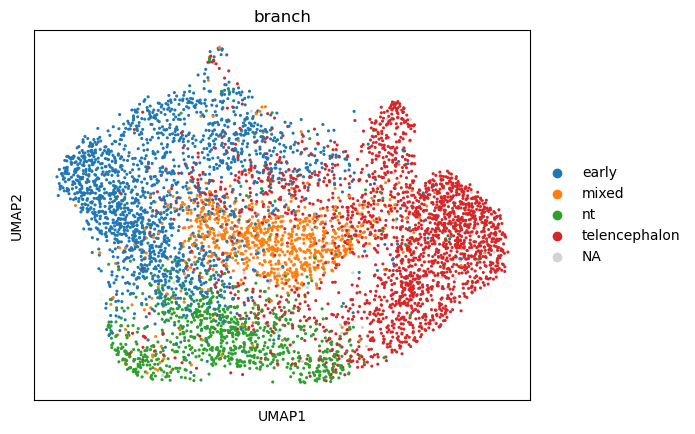

In [12]:
sc.pl.umap(adata, color=["branch"])

In [13]:
adata_atac_train_src.obsm[SCVI_LATENT_KEY] = adata[adata_atac_train_src.obs_names].obsm[SCVI_LATENT_KEY]
adata_atac_train_tgt.obsm[SCVI_LATENT_KEY] = adata[adata_atac_train_tgt.obs_names].obsm[SCVI_LATENT_KEY]

In [14]:
adata_atac_test_tgt = sc.read_h5ad("/lustre/groups/ml01/workspace/ot_perturbation/data/multiome/GLI3_KO_multiome_18d_adata_tgt_test_processed.h5ad")
adata_atac_test_src = sc.read_h5ad("/lustre/groups/ml01/workspace/ot_perturbation/data/multiome/GLI3_KO_multiome_18d_adata_arc_atac_test_processed.h5ad")

In [15]:
adata_atac_test_tgt.layers["peaks"] = adata_atac[adata_atac_test_tgt.obs_names, adata_atac_train_tgt.var_names].X
adata_atac_test_src.layers["peaks"] = adata_atac[adata_atac_test_src.obs_names, adata_atac_train_tgt.var_names].X

In [16]:
adata_test = anndata.concat((adata_atac_test_tgt, adata_atac_test_src), label="type", keys=["perturbed", "unperturbed"])
adata_test.X = adata_test.layers["peaks"]

In [17]:
adata_test.obsm[SCVI_LATENT_KEY] = model.get_latent_representation(adata_test)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       


In [18]:
adata_atac_test_src.obsm[SCVI_LATENT_KEY] = adata_test[adata_atac_test_src.obs_names].obsm[SCVI_LATENT_KEY]
adata_atac_test_tgt.obsm[SCVI_LATENT_KEY] = adata_test[adata_atac_test_tgt.obs_names].obsm[SCVI_LATENT_KEY]

In [19]:
sc.pp.neighbors(adata_test, use_rep=SCVI_LATENT_KEY)
sc.tl.umap(adata_test)

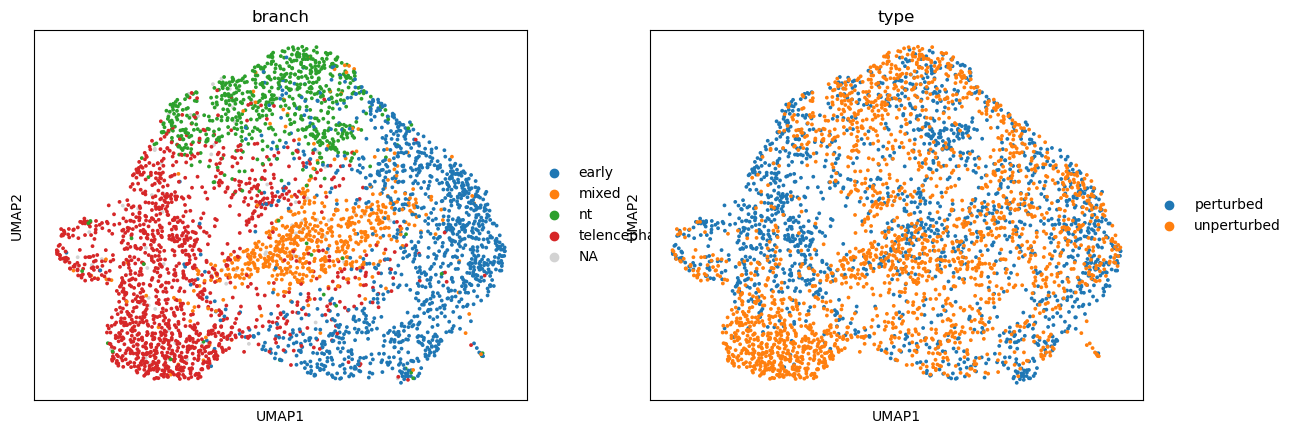

In [20]:
sc.pl.umap(adata_test, color=["branch", "type"])

In [21]:
adata_atac_train_tgt.write("/lustre/groups/ml01/workspace/ot_perturbation/data/multiome/GLI3_KO_multiome_18d_adata_tgt_train_processed_peakvi.h5ad")
adata_atac_train_src.write("/lustre/groups/ml01/workspace/ot_perturbation/data/multiome/GLI3_KO_multiome_18d_adata_src_atac_train_processed_peakvi.h5ad")

In [22]:
adata_atac_test_tgt.write("/lustre/groups/ml01/workspace/ot_perturbation/data/multiome/GLI3_KO_multiome_18d_adata_tgt_test_processed_peakvi.h5ad")
adata_atac_test_src.write("/lustre/groups/ml01/workspace/ot_perturbation/data/multiome/GLI3_KO_multiome_18d_adata_arc_atac_test_processed_peakvi.h5ad")